# Project 3 - Promoter Regions

In [1]:
# Les imports nécessaires pour ce mini-projet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
import utils
import project

## 2 Préliminaires : données et lecture des fichiers

In [2]:
cerevisae, chromos_flattened, counts, freqs = \
    utils.read_file("sequences/yeast_s_cerevisae_genomic_chr1-4.fna")
print("S. cerevisae contient", len(cerevisae), "chromosones et", \
      len(chromos_flattened), "nucléotides")
print("Voici les nombres d'occurrence et les fréquences d'apparition de chaque nucléotide :")
pd.DataFrame({'Occurrences': counts, 'Fréquence': freqs}, index=utils.nucleotide.keys())

S. cerevisae contient 4 chromosones et 2515853 nucléotides
Voici les nombres d'occurrence et les fréquences d'apparition de chaque nucléotide :


,Occurrences,Fréquence
A,754342,0.299835
C,505943,0.201102
G,503163,0.199997
T,752405,0.299066


## 3.1 Description empirique

Q2) D'après l'hypothèse d'indépendance des occurrences des lettres dans le génome, pour un mot $w = w_1.w_2\dots w_k$ de longueur $k$ donné, on connaît les fréquences des lettres $w_i$ le composant.
Donc, la probabilité de trouver ce mot est donnée par 
$$P(w) = \prod_{i=1}^{k} P(w_i).$$

On peut alors calculer le nombre d'occurrences du mot $w$ dans une séquence de longueur $l$ :
$$\text{comptage_attendu} = (l - k + 1)\cdot P(w),$$
où $l-k+1$ est le nombre de positions des occurrences du mot $w$.



Q3) Dans les histogrammes ci-dessous, les écarts entre les nombres d’occurrences attendus et ceux observés sont repérés avec la droite $\mathcal{L}: y = x$.
En effet,  plus la distance entre un point et cette droite est grande, plus l'écart est important.

On remarque dans les histogrammes obtenus la présence de mots qui détiennent une fonction spéciale, étant donné que l'écart entre le comptage observé et le comptage attendu augmente avec la taille des n-grammes, notamment pour les longueurs 6 et 8.

Ceci correspond bien à l'hypothèse sur la taille des région promoteurs, qui comptent souvent entre 6 et 10 nucléobases.
On trouve ainsi 3 mots pour la séquence MET, 1 mot pour PHO, et 1 mot pour GAL, qui sont susceptibles d'appartenir à une région promoteur.




En se basant que sur les fréquences des lettres qui composent un mot, cette modélisation n'offre pas une bonne <font color="RED" size="+1">**(approximation?)**</font> des occurrences observés.

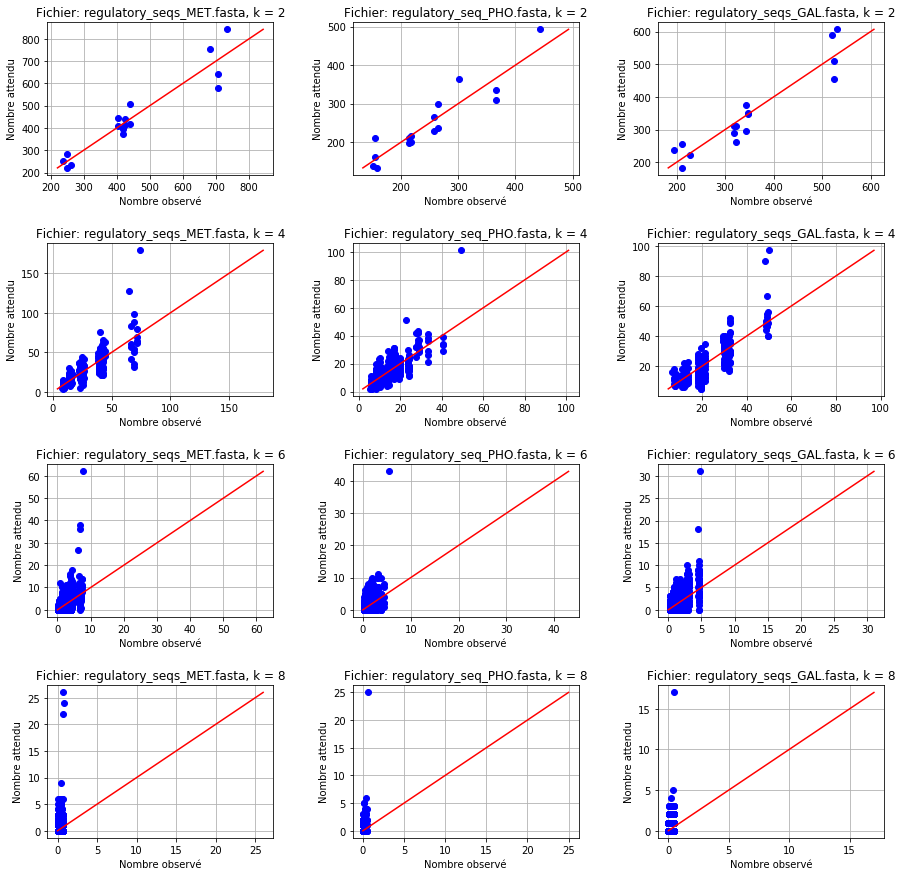

In [3]:
files = ["sequences/regulatory_seqs_MET.fasta", "sequences/regulatory_seq_PHO.fasta", \
         "sequences/regulatory_seqs_GAL.fasta"]
ks = [2, 4, 6, 8]

 # la séquence de nucléotides des séquences de contrôle
chromos_list = project.plot_scatter(files, ks)

# la distribution de probabilité des nucléotides sur la concaténation des 3 fichiers
probas = utils.nucleotide_frequency(chromos_list) 

## 3.2 Simulation de séquences aléatoires

Q3) On estime la probabilité d'observer un mot un certain nombre $n$ de fois par le proportion de séquences simulées où le mot est apparu au moins $n$ fois, c'est-à-dire
$$P(N \geq n) \approx P_{emp}(N \geq n) = \frac{1}{S}\cdot \sum_{i=1}^{S} \unicode{x1D7D9}_{N \geq n},$$
où $S$ est le nombre de simulations effectuées.

Q4) Vous trouverez dans la cellule ci-dessous les histogrammes des distributions du comptage d'occurrences $P_{emp}(N \geq n)$ pour les mots **ATCTGC**, **ATATAT**, **TTTAAA** et **AAAAAA**.

On remarque que les mots ATATAT et TTTAAA ont la même probabilité d'apparaître, puisque la probabilité empirique d'un nombre d'occurrences nul est zéro.
Cependant, leurs distributions de comptage d'occurrences est différente.
En effet, la distribution du mot ATATAT decroît plus vite que celle du mot TTTAAA. <font color="RED" size="+1">**(est-ce vrai ?)**</font>

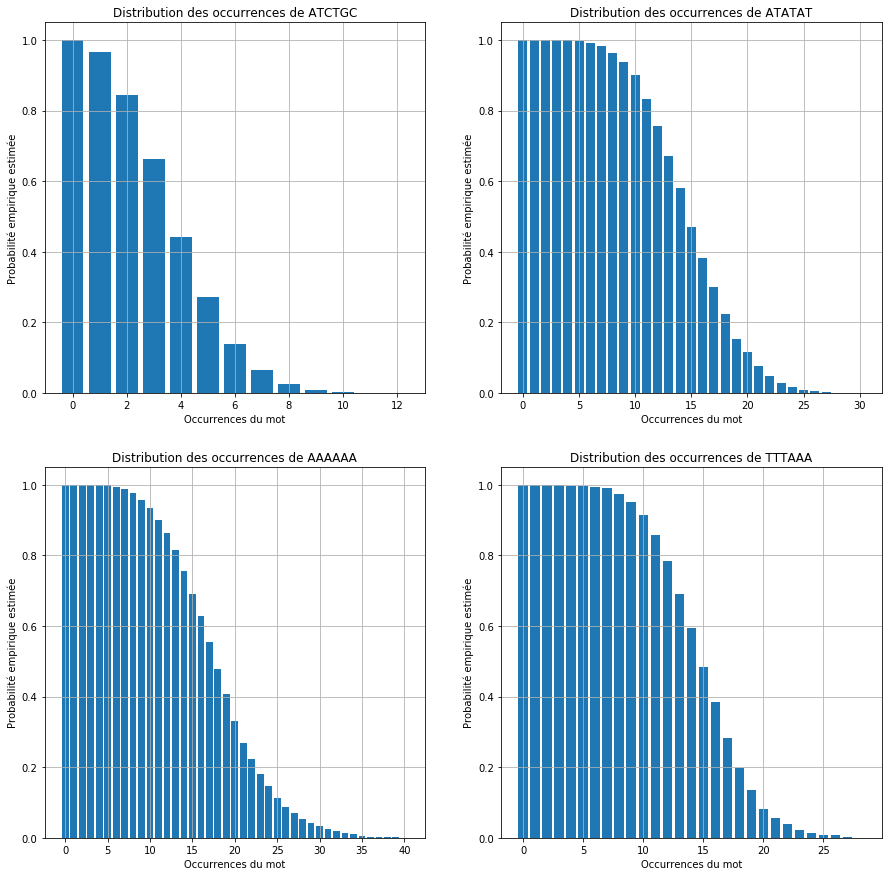

In [14]:
project.plot_histogram(chromos_list, probas, 1000)

Q5) On peut calculer un intervalle de confiance pour la probabilité d'observer un mot avec sa probabilité empirique : 
$$p_{emp} \sim \mathcal{N}\left(p, \sqrt \frac{p\cdot (1-p)}{n}\right),$$
où $n$ est le nombre (suffisamment grand) de simulations effectuées.

Pour un risque de 5 % ($z_{2.5\%} = 1.96$), on obtient l'intervalle
$$\left[p_{emp} - 1.96 \cdot \sqrt \frac{p_{emp}\cdot (1-p_{emp})}{n}, 
p_{emp} - 1.96 \cdot \sqrt \frac{p_{emp}\cdot (1-p_{emp})}{n} \right]$$

## 3.3 Modèles de dinucléotides et trinucléotides

Q1) On prend $\mathcal{X} = \{A, C, G, T\}$. Le modèle décrit correspond à une chaîne de Markov homogène d'ordre 1 car il remplit les 3 conditions :
- c'est un processus stochastique à temps discret avec les v.a. $X_i$ correpondant à la nucléobase à la position $i$ dans un génome ;
- l'ensemble des états $\mathcal{X}$ est fini ;
- la propriété de markov d'ordre 1 est vérifiée : $\forall i \geq 0, P(X_{i+1}|X_0,\dots, X_i) = P(X_{i+1}|X_i)$. Autrement dit, la loi du prochain nucléotide de la séquence ne dépend que du nucléotide précédent.

De plus, cette chaîne de Markov est homogène car les probabilités de transition ne dépendent pas d'une variable temporelle.

Par ailleurs, la probabilité stationnaire de cette chaîne correspond aux proportions des nucléobases dans un génome auxquelles on s'attend.

Q5) De la même manière que dans la question 3.1.2), le nombre d'occurrences attendu est
$$\text{comptage_attendu} = (l - k + 1)\cdot P(w),$$
sauf que, dans ce cas, la probabilité d'apparition du mot est calculée différemment. En effet, on utilise la propriété de Markov d'ordre 1 pour obtenir le résultat suivant :
$$
\begin{align}
    P(w) &= P(w_1)\cdot \prod_{i=2}^{k} P(w_i|w_1, \dots, w_{i-1}) \\
    P(w) &= P(w_1)\cdot \prod_{i=2}^{k} P(w_i|w_{i-1}).
\end{align}
$$

Pour la probabilité du premier nucléotide, à savoir $P(w_1)$, on a utilisé $\pi^\ast$, i.e. la distribution stationnaire de la chaîne de Markov, pour le calcul de la probabilité ci-dessus.
On a néanmoins remarqué lors du calcul de cette distribution que les $\pi^{(n)}$ convergent très rapidement.
C'est pourquoi il aurait été aussi sensé d'utiliser $\pi^{(0)}$.

Q6) <font color="RED" size="+1">**Ici, il me semble qu'il faut comparer les comptages attendu des deux modeles, on fait un nuage de points des deux comptages par rapport au comptages observé?**</font>

Q7)

## 3.4 Probabilité de mots

Q1) En faisant l'hypothèse d'indépendance des positions d'occurrences d'un mot **non chevauchant** $w$, on peut approcher le comptage du nombre d'occurrences dans une séquence de longueur $l$ avec la loi $Bin(P(w),\ l-k+1)$, où $P(w)$ sera calculée au moyen des modèles de nucléotides et de dinucléotides.

Q2) Etant donné que la longueur des séquences est au moins de l'ordre de 10 000, le deuxième paramètre de ladite loi binomiale est beaucoup plus grand que la probabilité $P(w)$.

De ce fait, on peut approcher cette loi avec la loi $Pois(P(w)\cdot (l-k+1))$.

Q3) Les figures ci-dessous montrent les distributions de probabilité empirique des mots ATCTGC, ATATAT, TTTAAA et AAAAAA obtenues en simulant 1000 séquences aléatoires avec le modèle de dinucléotides par chaîne de Markov.
Nous avons représenté également un nuage de points représentant le complémentaire de la répartition de la loi de Poisson avec le paramètre indiqué précédemment.

On remarque que l'histogramme représentant la probabilité empirique du mot ATCTGC, qui ne se chevauche pas, est très proche de la loi de Poisson. Malgré le fait que le mot ATATAT n'est pas chevauchant avec lui même, L’histogramme de la probabilité empirique de ce mot est quelque peu eloigné de la loi de Poisson correspondante.

En revanche, étant chavauchant avec lui même, l’histogramme de la probabilité empirique du mot AAAAAA s’écarte beaucoup de la loi de Poisson.

De ces faits, l’hypothèse d'indépendance en les différentes positions d'occurrences d'un mot et l'utilisation de la loi binomiale pour le comptage ne sont pas pértinents pour les mots qui se chevauchent avec eux-mêmes.

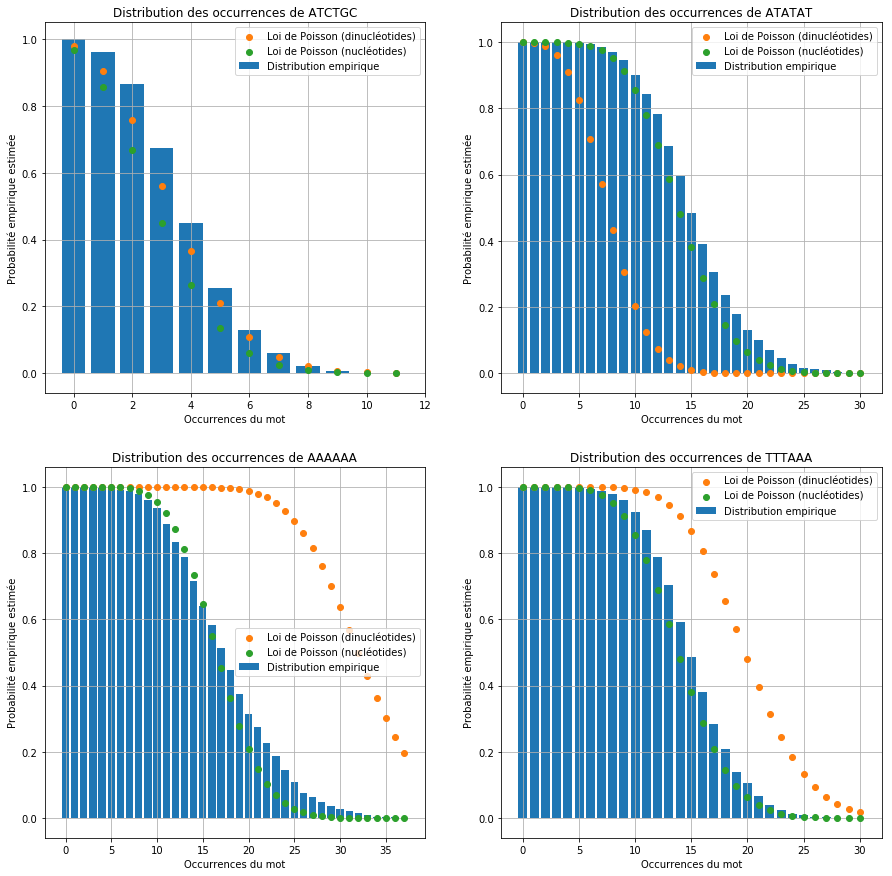

In [23]:
project.plot_histogram(chromos_list, probas, 1000, expected=True)

Q5) Un mot qui  apparait significativement plus qu'attendu est un mot dont la probabilité empirique est faible. Pour cela, nous avons fixé un seuil $\epsilon$ tel que les mots les plus innattendu sont ceux dont la probabilité empirique est inférieure à ce seuil.
$$P(N_{w} \geq n_{w}) < \epsilon$$
On fixe $\epsilon$ à 0.02

Pour $n = 2$, ce seuil n'est pas atteint, <font color="RED" size="+1">**EST CE NORMAL?**</font>

Pour $n = 4$, les mots les plus inattendus sont :

'AAAA', 'ACGT', 'CGTG', 'TATA'

Pour $n = 6$, les mots les plus inattendus sont :

'AAAAAA' , 'AAACGT' , 'AAGAAG' , 'ACGTGC' , 'ACGTGG' , 'CAAGAA' , 
'CACGTG' , 'CGTGGG' ,
'CTCATC' , 'GAAGAA , 'GCACGT' , 'TATATA' , 'TCATCT' , 'TGCCAA'


In [13]:
_, chromos_PHO, counts_PHO, freqs_PHO = utils.read_file(files[1])

In [56]:
project.unexpected_words(chromos_PHO, freqs_PHO, 6, 0.002)

word: AAAAAA		Occurrences: 43		P(N >= 43) = 0.0000
word: AAACGT		Occurrences: 7		P(N >= 7) = 0.0018
word: AAGAAG		Occurrences: 8		P(N >= 8) = 0.0017
word: ACGTGC		Occurrences: 5		P(N >= 5) = 0.0005
word: ACGTGG		Occurrences: 5		P(N >= 5) = 0.0001
word: CAAGAA		Occurrences: 10		P(N >= 10) = 0.0002
word: CACGTG		Occurrences: 6		P(N >= 6) = 0.0000
word: CGTGGG		Occurrences: 4		P(N >= 4) = 0.0001
word: CTCATC		Occurrences: 5		P(N >= 5) = 0.0009
word: GAAGAA		Occurrences: 9		P(N >= 9) = 0.0001
word: GCACGT		Occurrences: 5		P(N >= 5) = 0.0009
word: TATATA		Occurrences: 10		P(N >= 10) = 0.0000
word: TCATCT		Occurrences: 8		P(N >= 8) = 0.0000
word: TGCCAA		Occurrences: 7		P(N >= 7) = 0.0005
